<a href="https://colab.research.google.com/github/Maxmuleiv/Proyecto-Industrial/blob/master/AnalisisPobrezaMultidimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación Packages

In [1]:
%reset-f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx
from scipy.stats import pointbiserialr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importación BD

In [0]:
#url1="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/pobreza5d.csv?raw=true" #url base datos 
#url11="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/carencias.csv?raw=true"
#casen_hogares = pd.read_csv(url11,";") #importación base datos pobres 5d

In [0]:
#url2="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/dimensiones5D.csv?raw=true" #url base datos 
#url22="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/dimensiones.csv?raw=true"
#dimensiones = pd.read_csv(url22,";") #importación base datos por dimension

In [4]:
url3="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/CASENtipologias.csv?raw=true" #url base datos 
casen = pd.read_csv(url3,";", encoding='iso-8859-1') #importación base datos para calculo tipo hogares y tipologias de las carencias
casen.head()

,folio,o,id_vivienda,hogar,zona,tot_hog,tot_per,tot_par,tot_nuc,pco1,nucleo,pco2,yautcor,ytotcor,yautcorh,ymonecorh,ytotcorh,yoprcor,yoprcorh,ytrabajocor,ytrabajocorh,ypchautcor,ypc,ypchtrabajo,pobreza,qaut,qautr,numper,Allegamiento externo,Allegamiento interno,Hacinamiento,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,Pobreza 5D
0,110110020301,1,1101100203,1,Urbano,1,1,0,1,1,1,1,200000.0,211091.0,200000,211091,211091,200000.0,200000.0,200000.0,200000,200000,211091,200000,No pobres,III,III,1,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,Pobre
1,110110020601,1,1101100206,1,Urbano,1,2,0,1,1,1,1,130000.0,130000.0,463333,463333,463333,50000.0,50000.0,130000.0,130000,231667,231667,65000,No pobres,III,III,2,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,Pobre
2,110110020601,2,1101100206,1,Urbano,1,2,0,1,5,1,5,333333.0,333333.0,463333,463333,463333,NaN,NaN,NaN,130000,231667,231667,65000,No pobres,III,III,2,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,Pobre
3,110110030401,1,1101100304,1,Urbano,1,1,0,1,1,1,1,200000.0,200000.0,200000,200000,200000,200000.0,200000.0,200000.0,200000,200000,200000,200000,No pobres,III,III,1,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,Pobre
4,110110040201,1,1101100402,1,Urbano,1,1,0,1,1,1,1,442550.0,447482.0,442550,447482,447482,250000.0,250000.0,333333.0,333333,442550,447482,333333,No pobres,V,V,1,Sin allegamiento externo,Sin allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,Pobre


# Categorizacion por tipo de familia

In [5]:
casen2=np.array(casen);#print(casen2)
hogares_unicos,hogares_index,hogares_inv,hogares_count=np.unique(casen2[:,0],return_index=True, return_inverse=True, return_counts=True)
n_hogares=len(hogares_unicos)
n_personas=len(casen2[:,0])
cols=np.array(casen[["pco1","numper","tot_nuc"]])

dd=np.zeros((n_hogares,1))
ddd=np.zeros((n_personas,1))
for i,h in enumerate(hogares_unicos):
  #print(h,i)
  miembros=np.where(casen2[:,0]==h)[0]#;print(miembros)
  #n_miembros=len(miembros)
  m_cols=cols[miembros]
  a=0
  if 2 in m_cols[:,0] or 3 in m_cols[:,0]:
    a=1;#print(h,"tiene pareja")
  b=m_cols[0,1]
  c=m_cols[0,2]
  #print(a,b,c)
  if b==1: #hogar unipersonal
    d=1
  elif b==c:
    d=6 #hogar censal   
  elif b>1 and a==0 and c==1:
    d=2 #hogar monoparental nuclear
  elif b>1 and a==1 and c==1:
    d=3 #hogar biparental nuclear
  elif b>1 and a==0 and c>1:
    d=4 #hogar monoparental extendido
  elif b>1 and a==1 and c>1:
    d=5 #hogar biparental extendido
  
  dd[i]=d
  ddd[miembros]=d
# dd es un arreglo por hogar único que indica que tipo de hogar es
# ddd es el tipo de hogar al que pertenecen los miembros
casen["d"]=ddd.astype(int)
#casen.head()
casen[casen.d == 6].head()

,folio,o,id_vivienda,hogar,zona,tot_hog,tot_per,tot_par,tot_nuc,pco1,nucleo,pco2,yautcor,ytotcor,yautcorh,ymonecorh,ytotcorh,yoprcor,yoprcorh,ytrabajocor,ytrabajocorh,ypchautcor,ypc,ypchtrabajo,pobreza,qaut,qautr,numper,Allegamiento externo,Allegamiento interno,Hacinamiento,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,Pobreza 5D,d
470,110111291101,1,1101112911,1,Urbano,1,2,0,2,1,1,1,150000.0,150000.0,420000,420000,420000,NaN,NaN,150000.0,420000,210000,210000,210000,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,Hacinamiento crítico (5 y más),0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,Pobre,6
471,110111291101,2,1101112911,1,Urbano,1,2,0,2,11,2,1,270000.0,270000.0,420000,420000,420000,270000.0,270000.0,270000.0,420000,210000,210000,210000,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,Hacinamiento crítico (5 y más),0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,Pobre,6
556,110111561001,1,1101115610,1,Urbano,1,2,0,2,1,1,1,195000.0,205000.0,395000,405000,405000,195000.0,195000.0,195000.0,395000,197500,202500,197500,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,Pobre,6
557,110111561001,2,1101115610,1,Urbano,1,2,0,2,5,2,1,200000.0,200000.0,395000,405000,405000,NaN,NaN,200000.0,395000,197500,202500,197500,No pobres,III,III,2,Sin allegamiento externo,Con allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,Pobre,6
717,110111990601,1,1101119906,1,Urbano,1,2,0,2,1,1,1,240000.0,240000.0,240000,240000,240000,240000.0,240000.0,240000.0,240000,120000,120000,120000,Pobres no extremos,II,II,2,Sin allegamiento externo,Con allegamiento interno,"Sin hacinamiento (2,49 y menos)",0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,Pobre,6


# Definicion funciones

In [0]:
# FUNCION PARA OBTENCION HEATMAPS POR TIPO DE CORRELACION (PEARSON, KENDALL Y SPEARMAN)
def creacion_heatmap(Nombre_metodo,Tabla_variables,Negativos,Comentario_grafico):
  

  if  Negativos==False:
    color_min=-0.01
  else:
    color_min=-0.5
    
  Tabla_correlaciones = Tabla_variables.corr(method=Nombre_metodo)
  plt.figure(figsize = (20,10)) #arreglar el tamaño del gráfico

  mask = np.zeros(Tabla_correlaciones.shape, dtype=bool) #eliminacion datos simetricos
  mask[np.triu_indices(len(mask))] = True

  mapa=sb.heatmap(Tabla_correlaciones.values.round(2), xticklabels=Tabla_correlaciones.columns, # heatmap pearson
            yticklabels=Tabla_correlaciones.columns,vmin =color_min, vmax = 0.5, center = 0, cmap = "RdBu",annot=True, mask=mask, linewidths=3)


#antes fije vmax en 0.12 por si lo quiero volver a poner
  b, t = mapa.get_ylim() # identificar limites de corte
  mapa.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".png",bbox_inches="tight")
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".svg",bbox_inches="tight")

  return
  plt.show()

# set carencias y set dimensiones
jjj=["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]
hhh=["Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]



# Cálculo correlaciones carencias



In [7]:
casen_hogares=casen[["folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
casen_hogares=casen_hogares.drop_duplicates()
casen_hogares = casen_hogares.drop(['folio'],axis=1)
pearson5d = casen_hogares.corr(method='pearson')
pearson5d
print(len(casen_hogares.index))
print(len(casen.index))

12392
44972


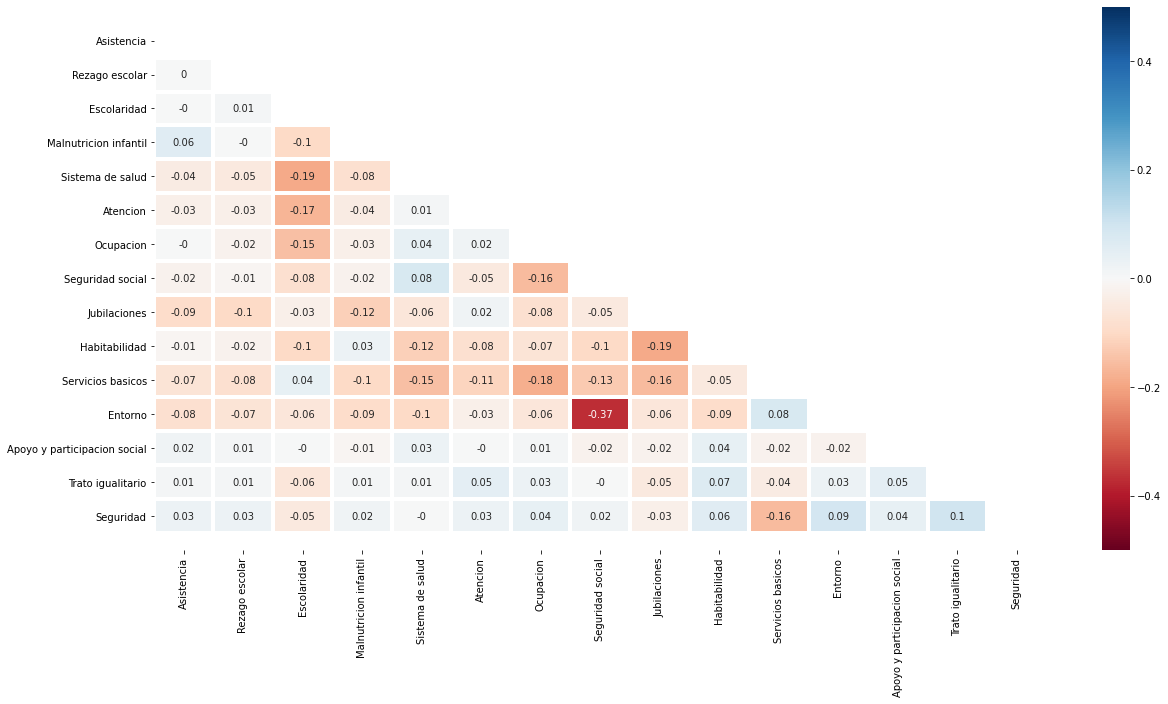

In [8]:
creacion_heatmap("pearson",casen_hogares,True,"Correlaciones")


In [0]:
# importacion datos correlaciones excel

pearson5d.to_excel(excel_writer = "pearson5d.xlsx")


# Cálculo correlaciones por tipo de hogar


total de hogares = 44972
total de hogares = 44972
total de h. unipersonal = 1246 - 2.77 %
total de h. monoparental nuclear = 6301 - 14.01 %
total de h. biparental nuclear = 19933 - 44.32 %
total de h. monoparental extendido = 6173 - 13.73 %
total de h. biparental extendido = 11142 - 24.78 %
total de h. censal = 177 - 0.39 %


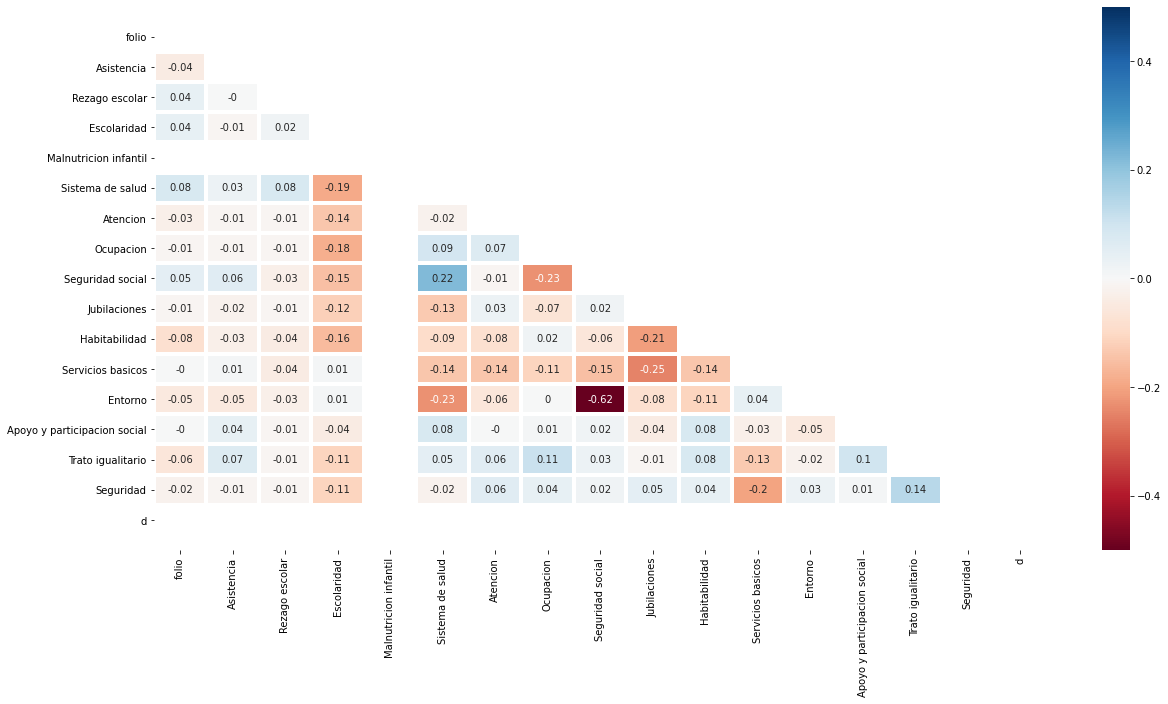

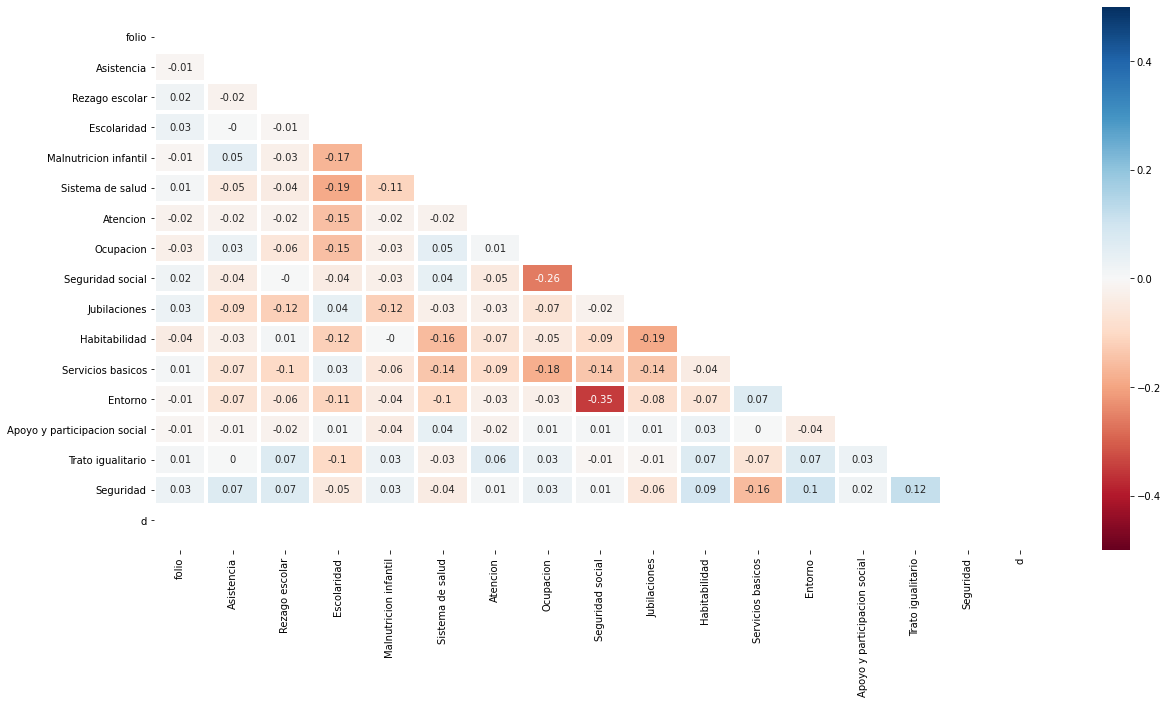

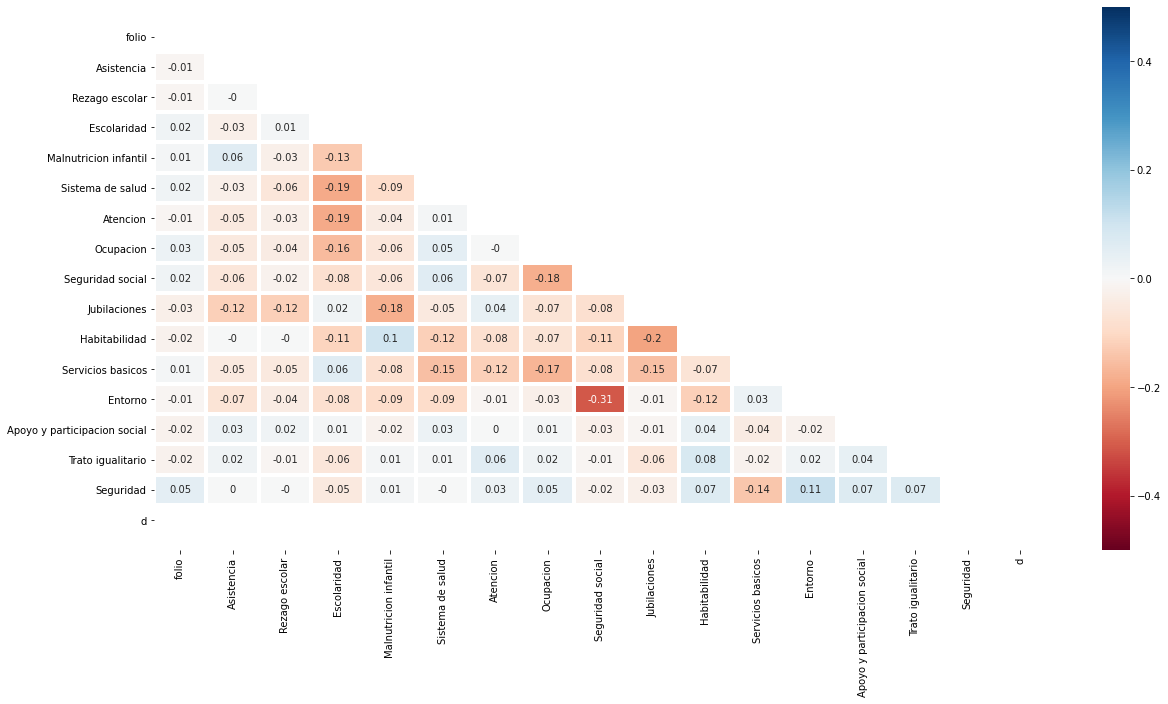

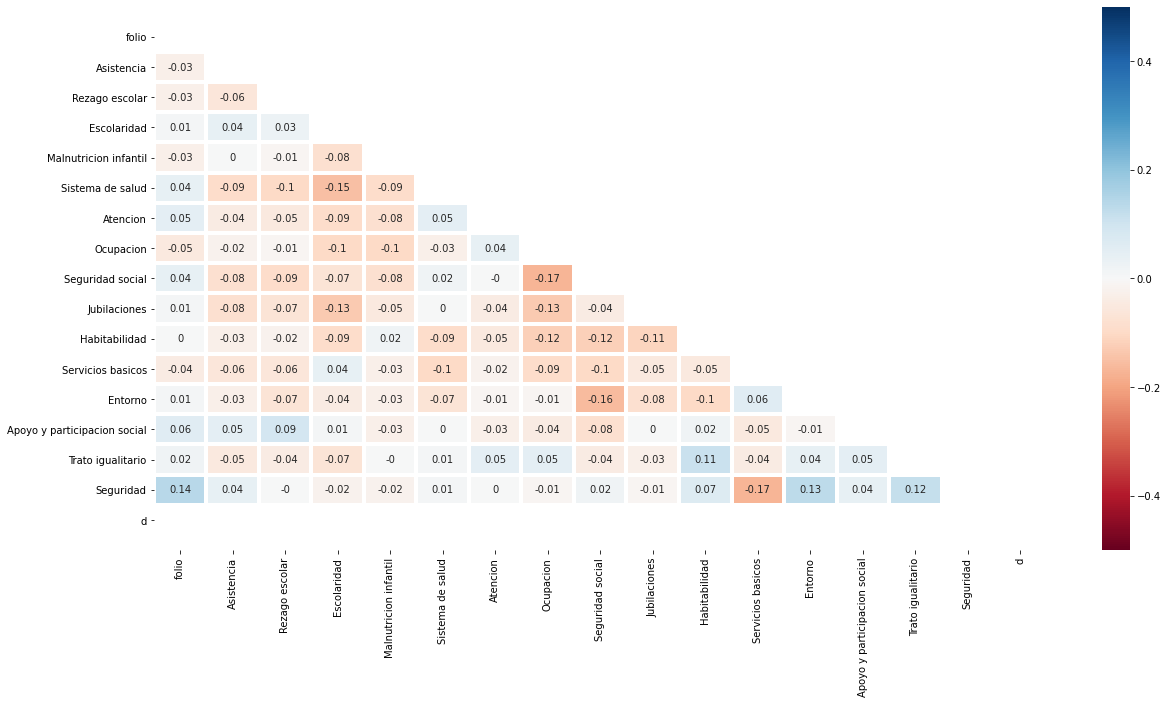

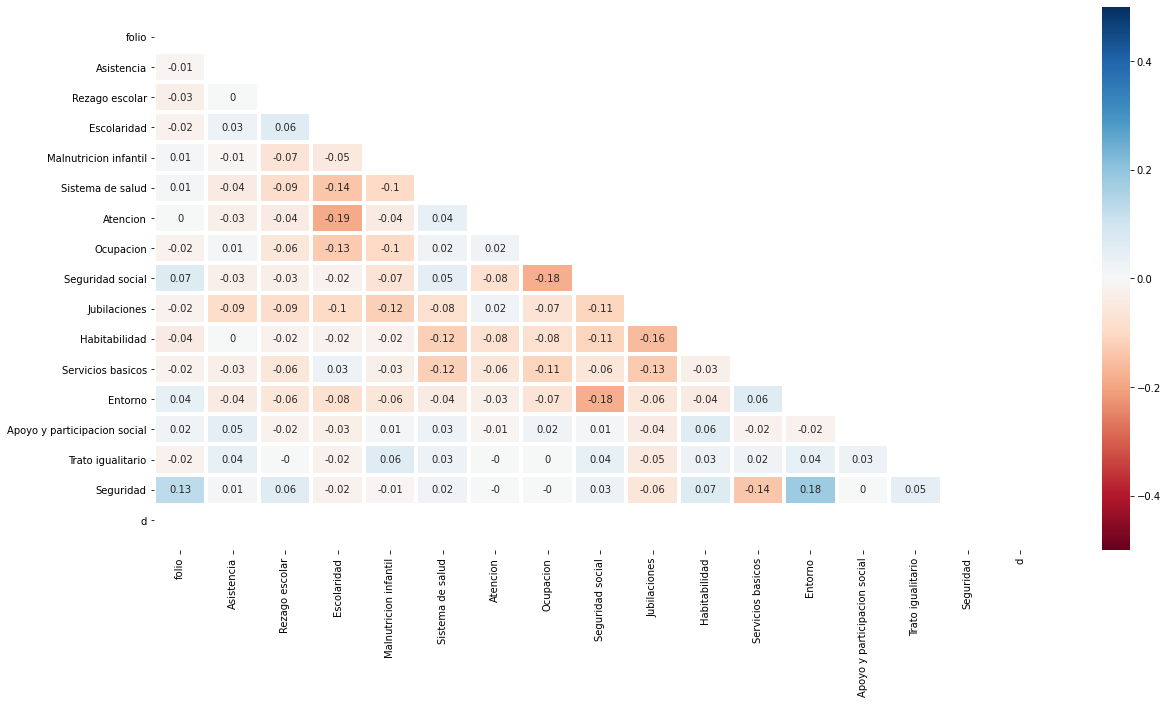

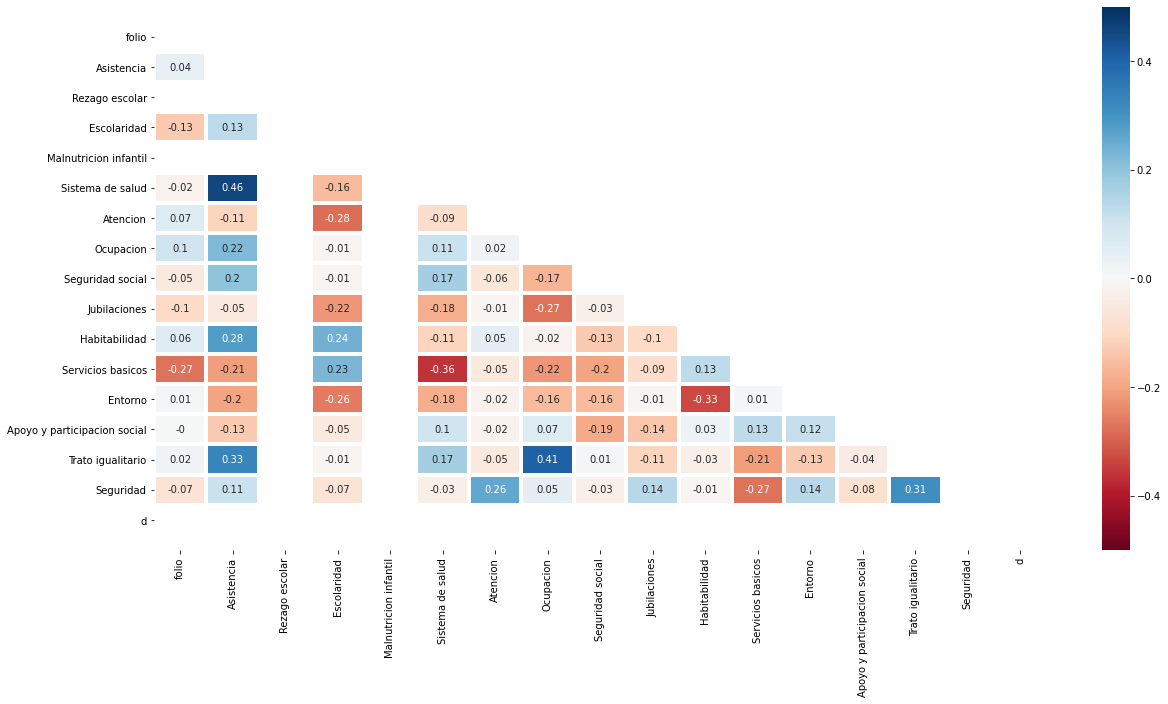

In [10]:
tipohogares=casen[["folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad","d"]]
tipohogares.head()


t_hogares=len(tipohogares.index)
print("total de hogares =",t_hogares)
hogar_unip=tipohogares[tipohogares.d == 1]
hogar_mononuc=tipohogares[tipohogares.d == 2]
hogar_binuc=tipohogares[tipohogares.d == 3]
hogar_monoex=tipohogares[tipohogares.d == 4]
hogar_biex=tipohogares[tipohogares.d == 5]
hogar_cen=tipohogares[tipohogares.d == 6]

t_unip=len(hogar_unip.index)
t_mononuc=len(hogar_mononuc.index)
t_binuc=len(hogar_binuc.index)
t_monoex=len(hogar_monoex.index)
t_biex=len(hogar_biex.index)
t_cen=len(hogar_cen.index)





print("total de hogares =",t_hogares)
print("total de h. unipersonal =",t_unip, "-",round(t_unip*100/t_hogares,2),"%")
print("total de h. monoparental nuclear =",t_mononuc,"-",round(t_mononuc*100/t_hogares,2),"%")
print("total de h. biparental nuclear =",t_binuc,"-",round(t_binuc*100/t_hogares,2),"%")
print("total de h. monoparental extendido =",t_monoex,"-",round(t_monoex*100/t_hogares,2),"%")
print("total de h. biparental extendido =",t_biex,"-",round(t_biex*100/t_hogares,2),"%")
print("total de h. censal =",t_cen,"-",round(t_cen*100/t_hogares,2),"%")


creacion_heatmap("pearson",hogar_unip,True,"Correlaciones")
creacion_heatmap("pearson",hogar_mononuc,True,"Correlaciones")
creacion_heatmap("pearson",hogar_binuc,True,"Correlaciones")
creacion_heatmap("pearson",hogar_monoex,True,"Correlaciones")
creacion_heatmap("pearson",hogar_biex,True,"Correlaciones")
creacion_heatmap("pearson",hogar_cen,True,"Correlaciones")


# Cálculo correlaciones dimensionales (5D)


In [11]:
# Calculo de indicador por dimension

dim=tipohogares.copy()
dim["Educacion"]=np.nan
dim["Salud"]=np.nan
dim["Trabajo y seguridad social"]=np.nan
dim["Vivienda y entorno"]=np.nan
dim["Redes y cohesion social"]=np.nan

for p in dim.index:
 # dim[p,"Educacion"]=dim[p,"Asistencia"]
  
  dim['Educacion'][p]=dim['Asistencia'][p]+dim['Rezago escolar'][p]+dim['Escolaridad'][p]
  dim['Salud'][p]=dim['Malnutricion infantil'][p]+dim['Sistema de salud'][p]+dim['Atencion'][p]
  dim['Trabajo y seguridad social'][p]=dim['Ocupacion'][p]+dim['Seguridad social'][p]+dim['Jubilaciones'][p]
  dim['Vivienda y entorno'][p]=dim['Habitabilidad'][p]+dim['Servicios basicos'][p]+dim['Entorno'][p]
  dim['Redes y cohesion social'][p]=dim['Apoyo y participacion social'][p]+dim['Trato igualitario'][p]+dim['Seguridad'][p]
  dim["Educacion"][p]=int(dim["Educacion"][p])
#dim[dim.Educacion == 3]
dim1=dim[["Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social","d"]]

#casen_hogares=casen[["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_l

In [12]:
dim2=dim1.drop(['d'],axis=1)
pearsonDim = dim1.corr(method='pearson')
pearsonDim

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social,d
Educacion,1.000000,-0.230315,-0.195242,-0.133706,-0.009286,0.088072
Salud,-0.230315,1.000000,-0.087620,-0.233176,0.035926,0.122922
Trabajo y seguridad social,-0.195242,-0.087620,1.000000,-0.444611,-0.014127,0.155333
Vivienda y entorno,-0.133706,-0.233176,-0.444611,1.000000,0.037269,-0.174451
Redes y cohesion social,-0.009286,0.035926,-0.014127,0.037269,1.000000,0.020356
d,0.088072,0.122922,0.155333,-0.174451,0.020356,1.000000


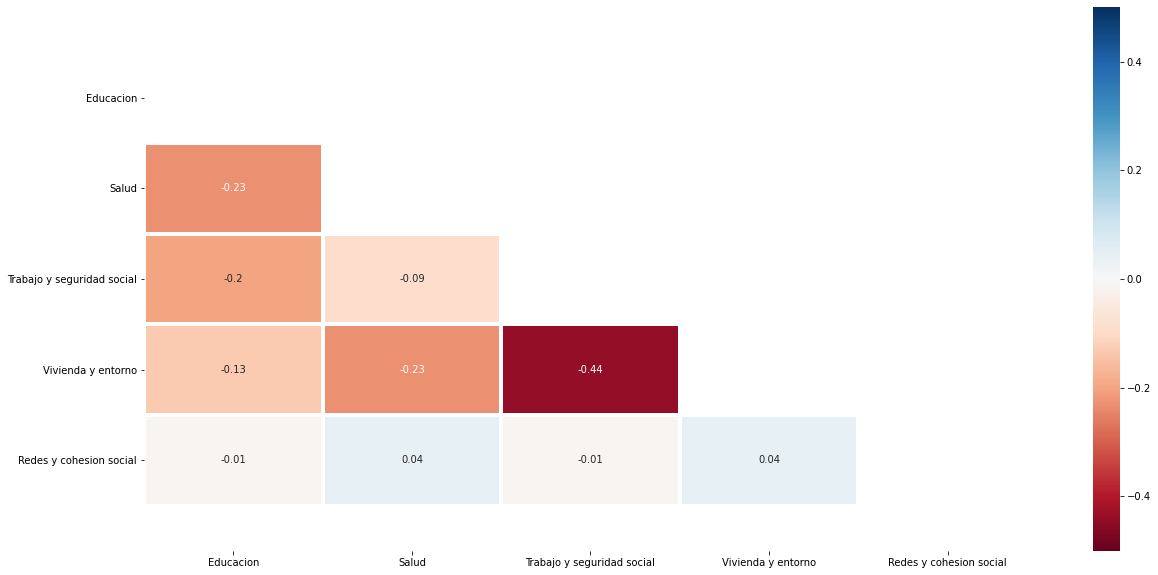

In [13]:
# OBTENCION HEATMAPS PEARSON, KENDALL Y SPEARMAN POR DIMENSIONES

creacion_heatmap("pearson",dim2,True,"DIM")


In [0]:
# exportacion datos correlaciones excel

pearsonDim.to_excel(excel_writer = "pearsonDim.xlsx")
dim.to_excel(excel_writer="hola.xlsx")


# Cálculo correlaciones dimensionales por hogar


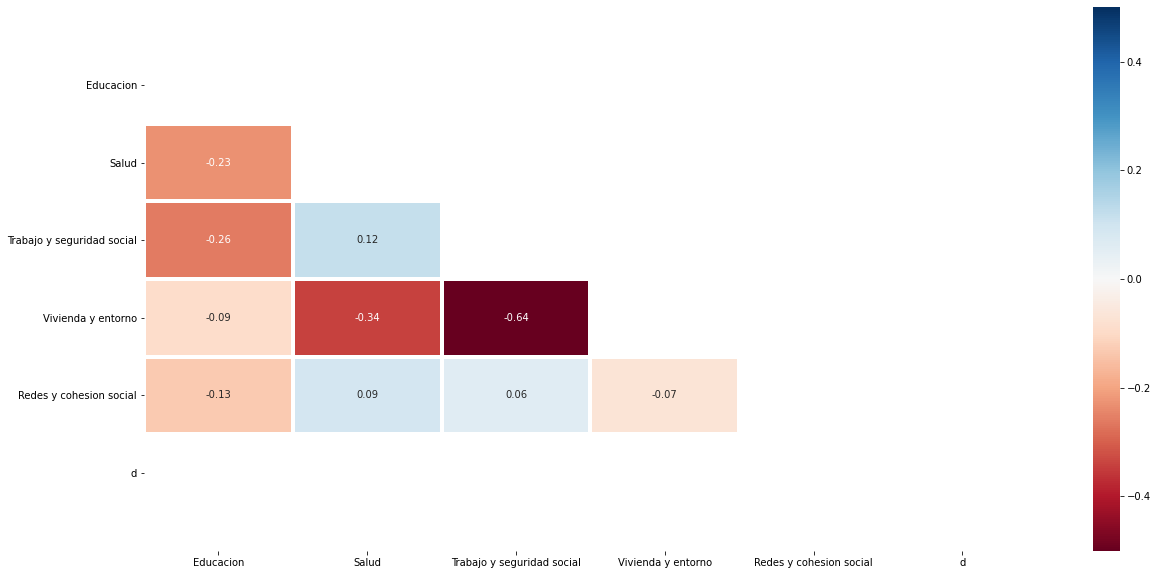

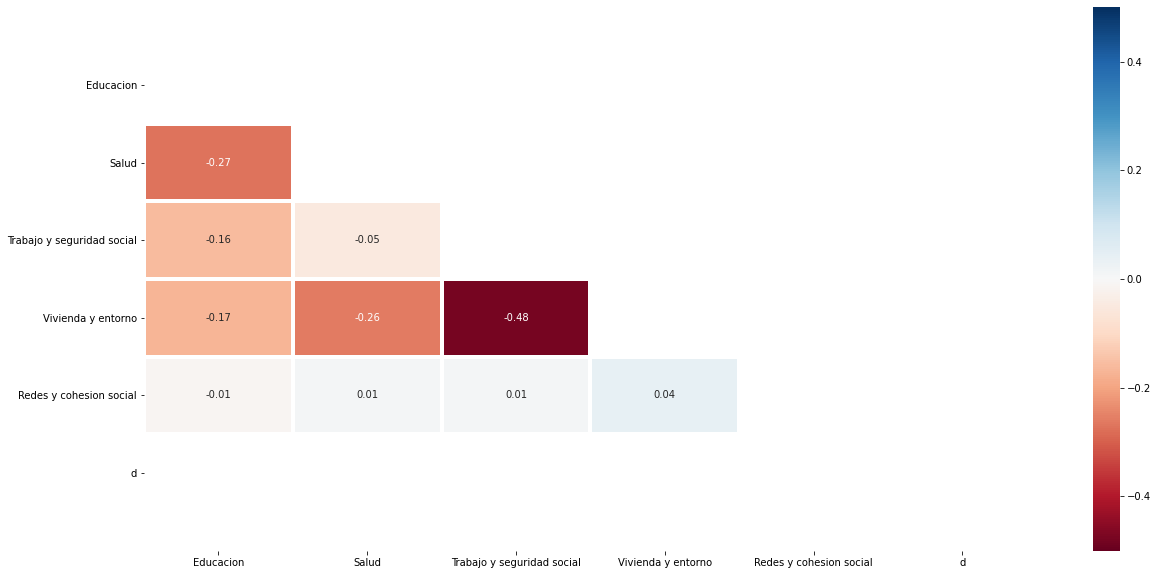

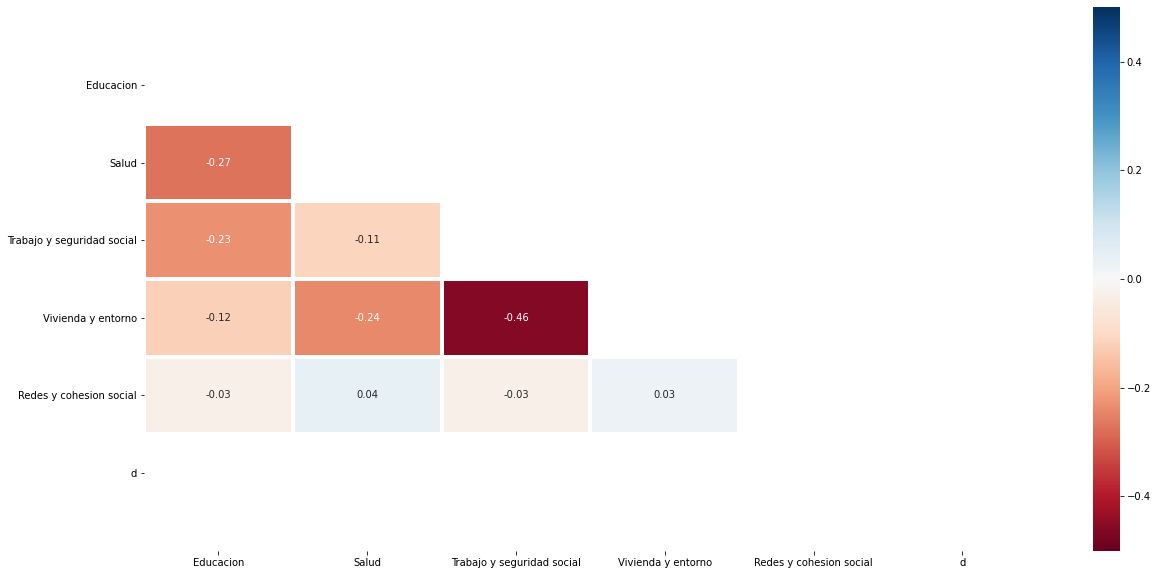

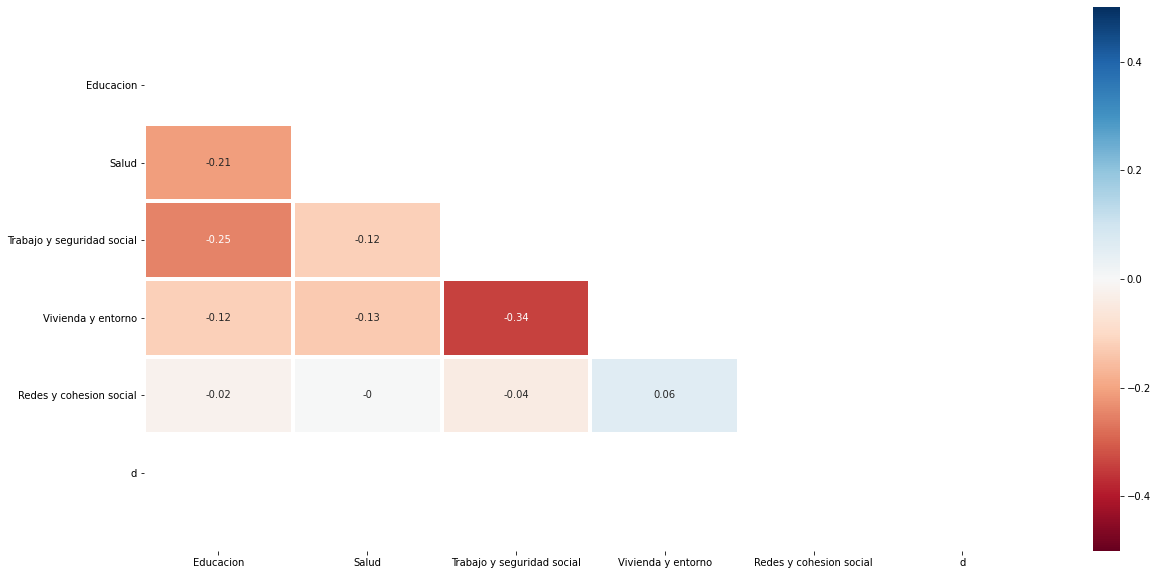

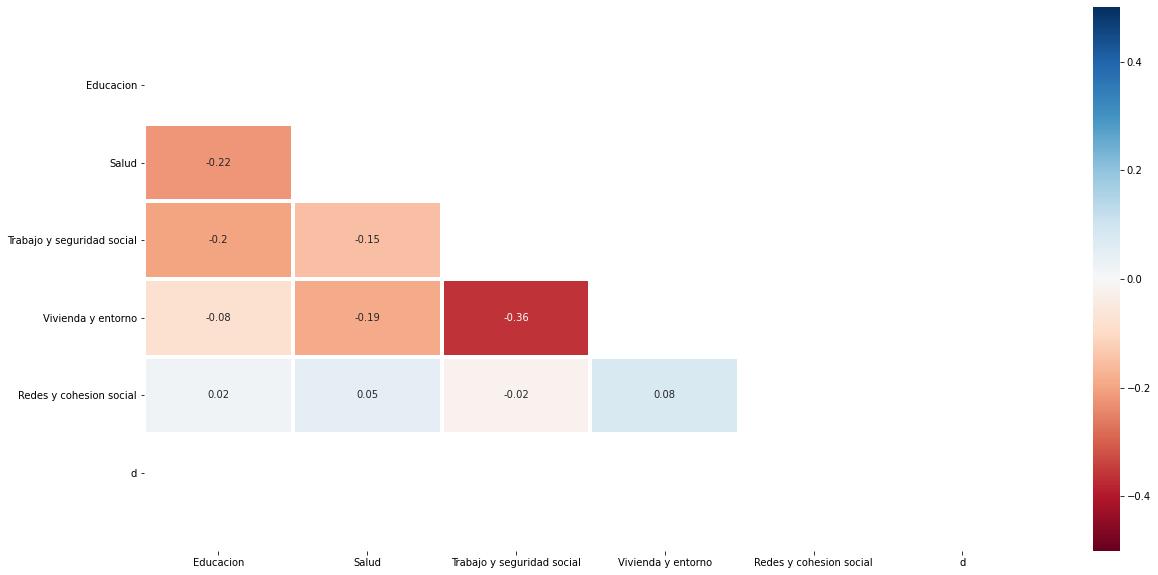

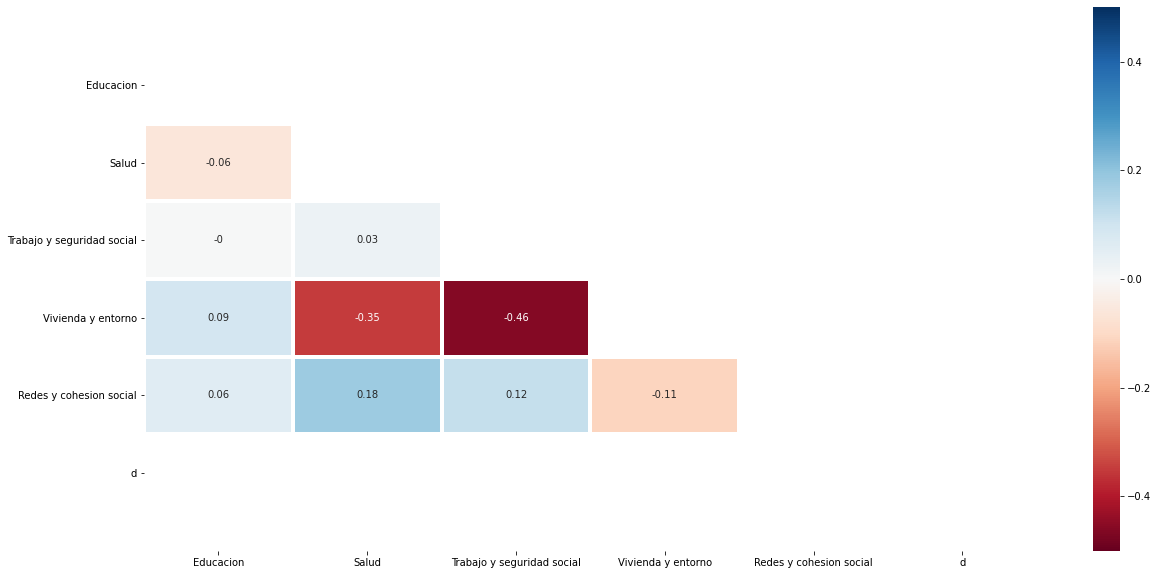

In [15]:
dim3=dim1.copy()
dim31=dim3[dim3.d==1]
dim32=dim3[dim3.d==2]
dim33=dim3[dim3.d==3]
dim34=dim3[dim3.d==4]
dim35=dim3[dim3.d==5]
dim36=dim3[dim3.d==6]

creacion_heatmap("pearson",dim31,True,"dim_unip")
creacion_heatmap("pearson",dim32,True,"dim_monuc")
creacion_heatmap("pearson",dim33,True,"dim_binuc")
creacion_heatmap("pearson",dim34,True,"dim_moex")
creacion_heatmap("pearson",dim35,True,"dim_biex")
creacion_heatmap("pearson",dim36,True,"dim_cen")

# Análisis red carencias

In [16]:
#transformación datos insice matriz de correlaciones, en este caso se usa pearson
indices = pearson5d.index.values
# transformación datos carencias a matriz, se emplea en este caso pearson
matrizCarencias = np.asmatrix(pearson5d)
#Creación de grafo con datos de la matriz de correlaciones Matriz5d
Gcarencias = nx.from_numpy_matrix(matrizCarencias)

#etiquetado de nosos para que coincidan con nombres de carencias
Gcarencias = nx.relabel_nodes(Gcarencias,lambda x: matrizCarencias[x,x]) # revisar aca, redefinicion de las etiquetas

#Muestra los arcos con sus respectivos pesos
Gcarencias.edges(data=True)

EdgeDataView([(1.0, 1.0, {'weight': 1.0})])

In [0]:
#Funcion para crear redes en base a correlaciones

def create_corr_network_1(G):
    #creacion lista de arcos y lista de pesos
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #Layout circular del grafo
    positions=nx.circular_layout(G)
    
    #Tamaño de la figura
    plt.figure(figsize=(15,15))

    #Ploteo de nodos
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    
    #Estilo etiquetas
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #Ploteo de arcos
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid')
    
    # Presentar el gráfico sin eje
    plt.axis('off')
   
    # Importación imagen grafo
    plt.savefig("grafocorr.png", format="PNG")
    plt.savefig("grafocorr.svg", format="SVG")
    plt.show() 
    create_corr_network_1(G)

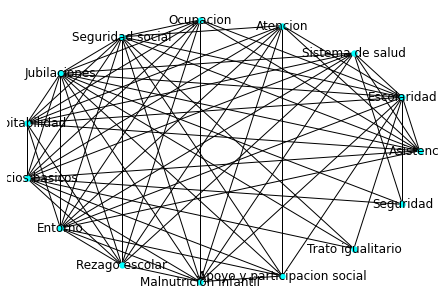

In [18]:
# Transform it in a links data frame (3 columns only):
links = pearson5d.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# eliminar correlaciones autorreferenciadas
links_filtered=links.loc[ (links['value'] < 0) & (links['var1'] != links['var2']) ]
links_filtered
 
# Creación gráfico
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
nx.draw_circular(G, with_labels=True, node_color='cyan', node_size=40, edge_color='black', linewidths=0.01, font_size=12)

#b, t = mapa5d.get_ylim() # identificar limites de corte
#mapa5d.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte

# Cálculo coeficiente de determinación R cuadrado para dimensiones

In [19]:
dim.head()

,folio,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,d,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
0,110110020301,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1.0,1.0,1.0,1.0,0.0
1,110110020601,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,2,1.0,0.0,3.0,2.0,2.0
2,110110020601,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,2,1.0,0.0,3.0,2.0,2.0
3,110110030401,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,1,0.0,0.0,1.0,3.0,2.0
4,110110040201,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0.0,0.0,1.0,2.0,2.0


In [20]:
dimensiones2=dim.T
dimensiones2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,44932,44933,44934,44935,44936,44937,44938,44939,44940,44941,44942,44943,44944,44945,44946,44947,44948,44949,44950,44951,44952,44953,44954,44955,44956,44957,44958,44959,44960,44961,44962,44963,44964,44965,44966,44967,44968,44969,44970,44971
folio,1.101100e+11,1.101100e+11,1.101100e+11,1.101100e+11,1.101100e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,1.101101e+11,...,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12,1.520130e+12
Asistencia,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Rezago escolar,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Escolaridad,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1

In [0]:
# cálculo coef. 
dimensionesR=np.corrcoef(dimensiones2)

In [22]:
pd.DataFrame(dimensionesR).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.000000,-0.013686,-0.014584,0.009323,-0.000436,0.019534,0.003483,-0.001089,0.038303,-0.015314,-0.025746,-0.004103,0.003204,0.003935,-0.009475,0.079253,0.000815,-0.006983,0.014182,0.016410,-0.017225,0.041085
1,-0.013686,1.000000,-0.007841,0.006213,0.039036,-0.043373,-0.037923,-0.006070,-0.041455,-0.092459,-0.008006,-0.064833,-0.064750,0.032862,0.014113,0.026591,0.072885,0.492134,-0.020099,-0.090271,-0.078448,0.038575
2,-0.014584,-0.007841,1.000000,0.022984,-0.029365,-0.069186,-0.036572,-0.035653,-0.029125,-0.098603,-0.009158,-0.073098,-0.059509,0.013812,0.000777,0.029628,0.043732,0.489114,-0.082044,-0.104016,-0.081079,0.023562
3,0.009323,0.006213,0.022984,1.000000,-0.091438,-0.172337,-0.169164,-0.132318,-0.059054,-0.027922,-0.086135,0.037065,-0.080734,-0.000640,-0.058394,-0.033395,0.043778,0.731680,-0.252685,-0.141179,-0.078760,-0.054995
4,-0.000436,0.039036,-0.029365,-0.091438,1.000000,-0.090749,-0.039809,-0.056007,-0.052781,-0.117543,0.031197,-0.084158,-0.079017,-0.014017,0.017475,0.012945,0.166594,-0.060432,0.588126,-0.144999,-0.072201,0.011733


In [0]:
# obtención coef. r cuadrado
dimensionesR2=dimensionesR**2

In [24]:
dimensionesR2=pd.DataFrame(dimensionesR2)
dimensionesR2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.000000e+00,0.000187,0.000213,0.000087,1.904244e-07,0.000382,0.000012,0.000001,0.001467,0.000235,0.000663,0.000017,0.000010,1.548321e-05,8.977742e-05,0.006281,6.638096e-07,0.000049,0.000201,0.000269,0.000297,0.001688
1,1.872942e-04,1.000000,0.000061,0.000039,1.523788e-03,0.001881,0.001438,0.000037,0.001718,0.008549,0.000064,0.004203,0.004193,1.079896e-03,1.991889e-04,0.000707,5.312190e-03,0.242196,0.000404,0.008149,0.006154,0.001488
2,2.126921e-04,0.000061,1.000000,0.000528,8.623145e-04,0.004787,0.001338,0.001271,0.000848,0.009722,0.000084,0.005343,0.003541,1.907611e-04,6.035729e-07,0.000878,1.912457e-03,0.239233,0.006731,0.010819,0.006574,0.000555
3,8.692055e-05,0.000039,0.000528,1.000000,8.360947e-03,0.029700,0.028616,0.017508,0.003487,0.000780,0.007419,0.001374,0.006518,4.091407e-07,3.409824e-03,0.001115,1.916499e-03,0.535356,0.063850,0.019932,0.006203,0.003024
4,1.904244e-07,0.001524,0.000862,0.008361,1.000000e+00,0.008235,0.001585,0.003137,0.002786,0.013816,0.000973,0.007082,0.006244,1.964697e-04,3.053630e-04,0.000168,2.775363e-02,0.003652,0.345893,0.021025,0.005213,0.000138


In [0]:
pd.DataFrame(dimensionesR).to_excel(excel_writer = "r.xlsx")
dimensionesR2.to_excel(excel_writer = "r_cuadrado.xlsx")

In [26]:
dim.cov()

,folio,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,d,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
folio,1.485670e+23,-1.564819e+09,-1.616853e+09,1.556849e+09,-6.167886e+07,2.728101e+09,3.420136e+08,-1.805527e+08,7.064456e+09,-2.532068e+09,-4.955918e+09,-7.078412e+08,5.277877e+08,4.120536e+08,-1.345829e+09,1.047861e+10,3.458718e+08,-1.624823e+09,3.008436e+09,4.351835e+09,-5.135971e+09,9.544829e+09
Asistencia,-1.564819e+09,8.799982e-02,-6.690630e-04,7.984609e-04,4.246363e-03,-4.662077e-03,-2.865703e-03,-7.743618e-04,-5.884311e-03,-1.176583e-02,-1.186112e-03,-8.607964e-03,-8.208129e-03,2.648463e-03,1.542833e-03,2.705825e-03,2.381277e-02,8.812922e-02,-3.281417e-03,-1.842450e-02,-1.800221e-02,6.897121e-03
Rezago escolar,-1.616853e+09,-6.690630e-04,8.273081e-02,2.864006e-03,-3.097279e-03,-7.210562e-03,-2.679621e-03,-4.409891e-03,-4.008439e-03,-1.216622e-02,-1.315503e-03,-9.410372e-03,-7.314330e-03,1.079296e-03,8.234625e-05,2.923203e-03,1.385357e-02,8.492575e-02,-1.298746e-02,-2.058455e-02,-1.804021e-02,4.084845e-03
Escolaridad,1.556849e+09,7.984609e-04,2.864006e-03,1.876930e-01,-1.452666e-02,-2.705315e-02,-1.866901e-02,-2.465115e-02,-1.224197e-02,-5.189273e-03,-1.863605e-02,7.187094e-03,-1.494659e-02,-7.528743e-05,-9.322564e-03,-4.962849e-03,2.088866e-02,1.913555e-01,-6.024882e-02,-4.208240e-02,-2.639555e-02,-1.436070e-02
Malnutricion infantil,-6.167886e+07,4.246363e-03,-3.097279e-03,-1.452666e-02,1.344707e-01,-1.205791e-02,-3.718674e-03,-8.831849e-03,-9.261300e-03,-1.849034e-02,5.713233e-03,-1.381249e-02,-1.238213e-02,-1.396445e-03,2.361388e-03,1.628377e-03,6.728310e-02,-1.337757e-02,1.186941e-01,-3.658349e-02,-2.048139e-02,2.593320e-03
Sistema de salud,2.728101e+09,-4.662077e-03,-7.210562e-03,-2.705315e-02,-1.205791e-02,1.312898e-01,1.897805e-03,5.114497e-03,9.591277e-03,-7.420677e-03,-2.204599e-02,-2.204190e-02,-1.228780e-02,2.778962e-03,1.713633e-03,1.555056e-05,3.816708e-03,-3.892579e-02,1.211297e-01,7.285097e-03,-5.637569e-02,4.508146e-03
Atencion,3.420136e+08,-2.865703e-03,-2.679621e-03,-1.866901e-02,-3.718674e-03,1.897805e-03,6.489026e-02,1.551968e-03,-6.883957e-03,1.452139e-03,-9.798503e-03,-1.039071e-02,-2.226236e-03,-4.612759e-04,3.816440e-03,1.460582e-03,3.409032e-03,-2.421434e-02,6.306940e-02,-3.879851e-03,-2.241545e-02,4.815746e-03
Ocupacion,-1.805527e+08,-7.743618e-04,-4.409891e-03,-2.465115e-02,-8.831849e-03,5.114497e-03,1.551968e-03,1.849208e-01,-3.615962e-02,-1.293234e-02,-1.690742e-02,-3.141504e-02,-8.838126e-03,4.938179e-04,3.897467e-03,4.510244e-03,4.866543e-02,-2.983540e-02,-2.165385e-03,1.358288e-01,-5.716058e-02,8.901528e-03
Seguridad social,7.064456e+09,-5.884311e-03,-4.008439e-03,-1.224197e-02,-9.261300e-03,9.591277e-03,-6.883957e-03,-3.615962e-02,2.289604e-01,-1.316791e-02,-2.642693e-02,-2.154362e-02,-5.734430e-02,-2.625038e-03,-9.463638e-05,1.541286e-03,3.168377e-02,-2.213472e-02,-6.553980e-03,1.796328e-01,-1.053148e-01,-1.178388e-03
Jubilaciones,-2.532068e+09,-1.176583e-02,-1.216622e-02,-5.189273e-03,-1.849034e-02,-7.420677e-03,1.452139e-03,-1.293234e-02,-1.316791e-02,1.840214e-01,-3.802230e-02,-2.701462e-02,-9.127399e-03,-1.544390e-03,-7.403095e-03,-4.634289e-03,3.735760e-02,-2.912132e-02,-2.445888e-02,1.579212e-01,-7.416431e-02,-1.358177e-02


# Obtención tipologías



In [218]:
# calculo frecuencia de cada carencia
suma_carencias=casen_hogares.sum()
suma_carencias


Asistencia                       893
Rezago escolar                   799
Escolaridad                     9288
Malnutricion infantil           1423
Sistema de salud                1912
Atencion                         893
Ocupacion                       2595
Seguridad social                7637
Jubilaciones                    3187
Habitabilidad                   6424
Servicios basicos               4125
Entorno                         3454
Apoyo y participacion social     986
Trato igualitario               1965
Seguridad                       1506
dtype: int64

In [250]:
# dataframe con factores externos

f1="zona" #numero de personas en el hogar
f2="numper" #rural o urbano
casen_tip=casen[[f1,f2,"folio","Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]]
casen_tip=casen_tip.drop_duplicates()
casen_tip=casen_tip.drop("folio",axis=1)
#casen_tip.head()

casen_tip_dim=casen_tip.copy()
casen_tip_dim["Educacion"]=np.nan
casen_tip_dim["Salud"]=np.nan
casen_tip_dim["Trabajo y seguridad social"]=np.nan
casen_tip_dim["Vivienda y entorno"]=np.nan
casen_tip_dim["Redes y cohesion social"]=np.nan

for p in casen_tip_dim.index:
 # dim[p,"Educacion"]=dim[p,"Asistencia"]
  
  casen_tip_dim['Educacion'][p]=casen_tip_dim['Asistencia'][p]+casen_tip_dim['Rezago escolar'][p]+casen_tip_dim['Escolaridad'][p]
  casen_tip_dim['Salud'][p]=casen_tip_dim['Malnutricion infantil'][p]+casen_tip_dim['Sistema de salud'][p]+casen_tip_dim['Atencion'][p]
  casen_tip_dim['Trabajo y seguridad social'][p]=casen_tip_dim['Ocupacion'][p]+casen_tip_dim['Seguridad social'][p]+casen_tip_dim['Jubilaciones'][p]
  casen_tip_dim['Vivienda y entorno'][p]=casen_tip_dim['Habitabilidad'][p]+casen_tip_dim['Servicios basicos'][p]+casen_tip_dim['Entorno'][p]
  casen_tip_dim['Redes y cohesion social'][p]=casen_tip_dim['Apoyo y participacion social'][p]+casen_tip_dim['Trato igualitario'][p]+casen_tip_dim['Seguridad'][p]


casen_tip_dim=casen_tip_dim[[f1,f2,"Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]]
casen_tip_dim.head()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to b

,zona,numper,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
0,Urbano,1,1.0,1.0,1.0,1.0,0.0
1,Urbano,2,1.0,0.0,3.0,2.0,2.0
3,Urbano,1,0.0,0.0,1.0,3.0,2.0
4,Urbano,1,0.0,0.0,1.0,2.0,2.0
5,Urbano,3,0.0,1.0,0.0,2.0,1.0


In [283]:
#  tipologias por carencias
tipos1=casen_tip.copy()
total1=len(tipos1[jjj].drop_duplicates().index)
print("total tipos =",total1)
tipos11=casen_hogares.groupby(["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]).size()
tipos11.to_excel(excel_writer = "tipologias.xlsx")



total tipos = 1849


In [271]:
# tipologias por peso dimensional
print("total tipos =",len(casen_tip_dim.drop_duplicates().index))
tiposdim2=casen_tip_dim.groupby(["Educacion","Salud","Trabajo y seguridad social","Vivienda y entorno","Redes y cohesion social"]).size()
tiposdim2.to_excel(excel_writer = "tipologias_dimensionales.xlsx")


total tipos = 1689


In [255]:
# tipologías por cuantiles

# paso 1: asignacion ponderación total
tipos2=casen_tip.copy()
tipos2["IntPob"]=np.nan
tipos2

mult1=7.5
mult2=(10/3)

for p in tipos2.index:
  c11=tipos2['Asistencia'][p]
  c12=tipos2['Rezago escolar'][p]
  c13=tipos2['Escolaridad'][p]
  c21=tipos2['Malnutricion infantil'][p]
  c22=tipos2['Sistema de salud'][p]
  c23=tipos2['Atencion'][p]
  c31=tipos2['Ocupacion'][p]
  c32=tipos2['Seguridad social'][p]
  c33=tipos2['Jubilaciones'][p]
  c41=tipos2['Habitabilidad'][p]
  c42=tipos2['Servicios basicos'][p]
  c43=tipos2['Entorno'][p]
  c51=tipos2['Apoyo y participacion social'][p]
  c52=tipos2['Trato igualitario'][p]
  c53=tipos2['Seguridad'][p]
  k=1+5+c12
  c=round(mult1*(c11+c12+c13+c21+c22+c23+c31+c32+c33+c41+c42+c43)+mult2*(c51+c52+c53),2)

  tipos2['IntPob'][p]=c


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [286]:
# paso 2: definición cuantiles 

cuant=tipos2[["IntPob"]].quantile([.4, .6, .8, .9, 1], axis = 0)

for p in cuant.index:
  print("cuantil=",p)
  j=cuant["IntPob"][p]
  k=len(tipos2[tipos2.IntPob<=j])
  print("marca=",j)
  print("frecuencia acumulada=",k)
  print("frecuencia acumulada porcentual=",round(k*100/12392,2),"%")
  print("____________________________")

cuantil= 0.4
marca= 22.5
frecuencia acumulada= 5739
frecuencia acumulada porcentual= 46.31 %
____________________________
cuantil= 0.6
marca= 25.83
frecuencia acumulada= 7786
frecuencia acumulada porcentual= 62.83 %
____________________________
cuantil= 0.8
marca= 30.0
frecuencia acumulada= 10347
frecuencia acumulada porcentual= 83.5 %
____________________________
cuantil= 0.9
marca= 33.33
frecuencia acumulada= 11200
frecuencia acumulada porcentual= 90.38 %
____________________________
cuantil= 1.0
marca= 63.33
frecuencia acumulada= 12392
frecuencia acumulada porcentual= 100.0 %
____________________________


In [269]:
m1=22.5
m2=25.83
m3=30.0
m4=33.33
m5=63.33

tipos2["marca"]=np.nan

for p in tipos2.index:
  if tipos2['IntPob'][p]<=m1:
    tipos2["marca"][p]=m1

  elif tipos2['IntPob'][p]<=m2:
    tipos2["marca"][p]=m2

  elif tipos2['IntPob'][p]<=m3:
    tipos2["marca"][p]=m3

  elif tipos2['IntPob'][p]<=m4:
    tipos2["marca"][p]=m4

  elif tipos2['IntPob'][p]<=m5:
    tipos2["marca"][p]=m5

tipos21=tipos2[tipos2.marca==m1]
tipos22=tipos2[tipos2.marca==m2]
tipos23=tipos2[tipos2.marca==m3]
tipos24=tipos2[tipos2.marca==m4]
tipos25=tipos2[tipos2.marca==m5]

acum=len(tipos21)
print("marca:",m1)
print("frecuencia:",len(tipos21))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos22)
print("marca:",m2)
print("frecuencia:",len(tipos22))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos23)
print("marca:",m3)
print("frecuencia:",len(tipos23))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos24)
print("marca:",m4)
print("frecuencia:",len(tipos24))
print("frecuencia acumulada:",acum)
print("________________________________________")
acum=acum+len(tipos25)
print("marca:",m5)
print("frecuencia:",len(tipos25))
print("frecuencia acumulada:",acum)
print("________________________________________")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying t

marca: 22.5
frecuencia: 5739
frecuencia acumulada: 5739
________________________________________
marca: 25.83
frecuencia: 2047
frecuencia acumulada: 7786
________________________________________
marca: 30.0
frecuencia: 2561
frecuencia acumulada: 10347
________________________________________
marca: 33.33
frecuencia: 853
frecuencia acumulada: 11200
________________________________________
marca: 63.33
frecuencia: 1192
frecuencia acumulada: 12392
________________________________________


In [292]:
jjj=["Asistencia","Rezago escolar","Escolaridad","Malnutricion infantil","Sistema de salud","Atencion","Ocupacion","Seguridad social","Jubilaciones","Habitabilidad","Servicios basicos","Entorno","Apoyo y participacion social","Trato igualitario","Seguridad"]

# intervalo m1
total21=len(tipos21[jjj].drop_duplicates().index)
total22=len(tipos22[jjj].drop_duplicates().index)
total23=len(tipos23[jjj].drop_duplicates().index)
total24=len(tipos24[jjj].drop_duplicates().index)
total25=len(tipos25[jjj].drop_duplicates().index)
print("total tipos =",total21+total22+total23+total24+total25)
print("total tipos m1 =",total21)
print("total tipos m2 =",total22)
print("total tipos m3 =",total23)
print("total tipos m4 =",total24)
print("total tipos m5 =",total25)


tipos_m1=tipos21.groupby(jjj).size()
tipos_m1.to_excel(excel_writer = "tipologias_m1.xlsx")

tipos_m2=tipos22.groupby(jjj).size()
tipos_m2.to_excel(excel_writer = "tipologias_m2.xlsx")

tipos_m3=tipos23.groupby(jjj).size()
tipos_m3.to_excel(excel_writer = "tipologias_m3.xlsx")

tipos_m4=tipos24.groupby(jjj).size()
tipos_m4.to_excel(excel_writer = "tipologias_m4.xlsx")

tipos_m5=tipos25.groupby(jjj).size()
tipos_m5.to_excel(excel_writer = "tipologias_m5.xlsx")



total tipos = 1849
total tipos m1 = 176
total tipos m2 = 342
total tipos m3 = 386
total tipos m4 = 311
total tipos m5 = 634


In [299]:
tipos25

,zona,numper,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad,IntPob,marca
1,Urbano,2,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,51.67,63.33
3,Urbano,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,36.67,63.33
14,Urbano,2,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,36.67,63.33
16,Urbano,6,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,37.50,63.33
79,Urbano,4,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,36.67,63.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44910,Urbano,4,0,0,1,0,1,0,0,1,1,1,0,0,0,1,0,40.83,63.33
44922,Urbano,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,37.50,63.33
44931,Rural,4,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,37.50,63.33
44940,Rural,2,0,0,1,0,1,0,0,1,1,0,1,1,0,1,0,48.33,63.33
